In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from pandas.tseries.holiday import USFederalHolidayCalendar as hcal
import pickle
import psycopg2
import config
import itertools as itt
from datetime import datetime
from psycopg2.extras import execute_values
from sklearn.svm import SVC
import os
import sys

In [2]:
with open('sql/logit_reservations.sql','r') as f:
    sql = f.read()
con = psycopg2.connect(dbname=config.redshift['dbname'],
                        host=config.redshift['host'],
                        port=config.redshift['port'],
                        user=config.redshift['user'],
                        password=config.redshift['password'])
df = pd.read_sql(sql, con)
con.close()

In [3]:
rolling_avg_spend = pd.DataFrame(df.groupby(['date_start','region'])['daily_spend'].mean().rolling(window=21, min_periods=1).mean()).reset_index()
rolling_avg_spend.columns = ['date_start','region','rolling_avg_spend']
df = pd.merge(df, rolling_avg_spend, how='left', on=['date_start','region'])

In [4]:
holidays = hcal().holidays(start='2017-05-05', end='2023-1-01')
df['is_holiday'] = df['date_start'].apply(lambda x: 1 if x in holidays else 0)
df['year'] = df['date_start'].apply(lambda x: x.year)
df['season'] = df['month'].apply(lambda x: 'winter' if np.isin(x, ['Dec','Jan','Feb']) == True
                                            else ('spring' if np.isin(x, ['Mar','Apr','May']) == True
                                            else ('summer' if np.isin(x, ['Jun','Jul','Aug']) == True
                                            else 'fall')))
df['is_apr_thru_jul'] = df['month'].apply(lambda x: 1 if x in ['Apr','May','Jun','Jul'] else 0)
df['is_neutral_color'] = df['color'].apply(lambda x: 1 if x in ['White','Grey','Silver','Black'] else 0)

In [21]:
orig = df.copy()

In [5]:
target=['is_reserved']
num_cols = ['rolling_avg_spend', 'number_available_cars', 'is_canvas_2_0',
            # 'focus_count', 'fusion_count', 'fiesta_count', 'escape_count',
            # 'c-max hybrid_count', 'explorer_count', 'edge_count', 'mustang_count',
            'is_weekend', 'is_holiday', 'vehicle_fee', 'is_neutral_color',
            'min_vehicle_fee', 'is_apr_thru_jul']
cat_cols = ['region', 'model', 'model_year']

In [6]:
dummy_list = []
for var in cat_cols:
    x = pd.get_dummies(df[var])
    dummy_list.append(list(x))
    df = pd.concat([df, x], axis=1)
dummy_list = list(itt.chain.from_iterable(dummy_list))

In [83]:
# df.info()

In [54]:
orig_features = ['region','year','month','make','model','model_year','alg_trim','color'] + num_cols

In [7]:
features = num_cols + dummy_list

In [8]:
X = df[features].fillna(0)
y = df[target].values.ravel()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=101,
                                                    test_size=0.25)

In [10]:
ros = SMOTE()
X_train, y_train = ros.fit_sample(X_train, y_train)

In [11]:
m = GradientBoostingClassifier(n_estimators=100, max_depth=10,
                               max_features='sqrt', min_samples_leaf=3)

In [12]:
model = m.fit(X_train, y_train)

In [13]:
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrated.fit(X, y)
scores = calibrated.predict_proba(X)[:, 1]

In [14]:
y_pred = model.predict(X)

In [55]:
inventory_scores = pd.concat([orig[orig_features], pd.Series(y), pd.Series(y_pred), pd.Series(scores)], axis=1)

In [56]:
inventory_scores.columns = orig_features + ['is_reserved', 'predict_reserved', 'proba_reserved']

In [65]:
groupby_cols = ['model', 'model_year', 'alg_trim']

In [68]:
unique_months = inventory_scores['month'].unique()
unique_cities = inventory_scores['region'].unique()
with open('output.csv', 'w') as f:
    for y in unique_cities:
        print("\n{} Canvas 2.0 Best and Worst Performing Cars by Month".format(y), file=f)
        partition_scores = inventory_scores[inventory_scores['region']==y]
        for i in unique_months:
            performance = partition_scores[(partition_scores['month']==i) & (partition_scores['is_canvas_2_0']==1) & (partition_scores['make']!='Lincoln')].groupby(groupby_cols)['proba_reserved'].agg(['mean'])
            print("\n5 Highest Probabilities in {}".format(i), file=f)
            print(performance.sort_values(by='mean',ascending=False).head(5), sep='\t', file=f)
            print("\n5 Lowest Probabilities in {}".format(i), file=f)
            print(performance.sort_values(by='mean',ascending=True).head(5), sep='\t', file=f)


In [163]:
X_train = sm.add_constant(X_train) ## add an intercept (beta_0) to our model
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit() ## note sm.OLS(output, input)
ols_preds = model.predict(X_test)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     64.96
Date:                Fri, 04 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:24:00   Log-Likelihood:                -1641.5
No. Observations:               18729   AIC:                             3339.
Df Residuals:                   18701   BIC:                             3559.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0682      0.007      9.693      0.000       0.054       0.082
rolling_avg_spend       2.934e-05   3.87e-06      7.576      0.000    2.17e-05    3.69e-05
number_available_cars     -0.0024      0.000    -14.662      0.000      -0.003      -0.002
is_canvas_2_0             -0.0819      0.008    -10.424      0.000      -0.097      -0.067
is_weekend                -0.0237      0.004     -5.383      0.000      -0.032      -0.015
is_holiday                -0.0311      0.013     -2.306      0.021      -0.057      -0.005
vehicle_fee               -0.0001   2.99e-05     -3.969      0.000      -0.000      -6e-05
is_neutral_color           0.0217      0.005      4.222      0.000       0.012       0.032
min_vehicle_fee            0.0002    4.5e-05      4.223      0.000       0.000       0.000
is_apr_thru_jul            0.0308      0.005      5.963      0.000       0.021       0.041
Los Angeles               -0.0104      0.004     -2.576      0.010      -0.018      -0.002
San Francisco Bay Area     0.0786      0.005     17.116      0.000       0.070       0.088
C-Max Hybrid              -0.0046      0.015     -0.305      0.760      -0.034       0.025
Continental                0.0113      0.017      0.671      0.502      -0.022       0.044
Edge                      -0.0506      0.009     -5.822      0.000      -0.068      -0.034
Escape                    -0.0086      0.006     -1.435      0.151      -0.020       0.003
Explorer                  -0.0143      0.007     -2.168      0.030      -0.027      -0.001
F-150                     -0.0350      0.014     -2.490      0.013      -0.062      -0.007
Fiesta                     0.1290      0.012     10.714      0.000       0.105       0.153
Flex                      -0.0782      0.016     -4.825      0.000      -0.110      -0.046
Focus                      0.1404      0.009     16.115      0.000       0.123       0.157
Fusion                     0.0250      0.007      3.717      0.000       0.012       0.038
MKC                       -0.0039      0.011     -0.349      0.727      -0.026       0.018
MKX                       -0.0065      0.012     -0.555      0.579      -0.029       0.016
MKZ                       -0.0083      0.010     -0.789      0.430      -0.029       0.012
Mustang                    0.0003      0.009      0.027      0.979      -0.018       0.019
Navigator                  0.0222      0.024      0.913      0.361      -0.025       0.070
Taurus                    -0.0501      0.024     -2.086      0.037      -0.097      -0.003
2015                       0.0513      0.005      9.940      0.000       0.041       0.061
2016                      -0.0125      0.007     -1.840      0.066      -0.026       0.001
2017                       0.0294      0.009      3.438      0.001       0.013  

In [164]:
logreg = LogisticRegression(solver='warn', fit_intercept=True)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [165]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[5684   17]
 [ 513   30]]


              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5701
           1       0.64      0.06      0.10       543

   micro avg       0.92      0.92      0.92      6244
   macro avg       0.78      0.53      0.53      6244
weighted avg       0.89      0.92      0.88      6244



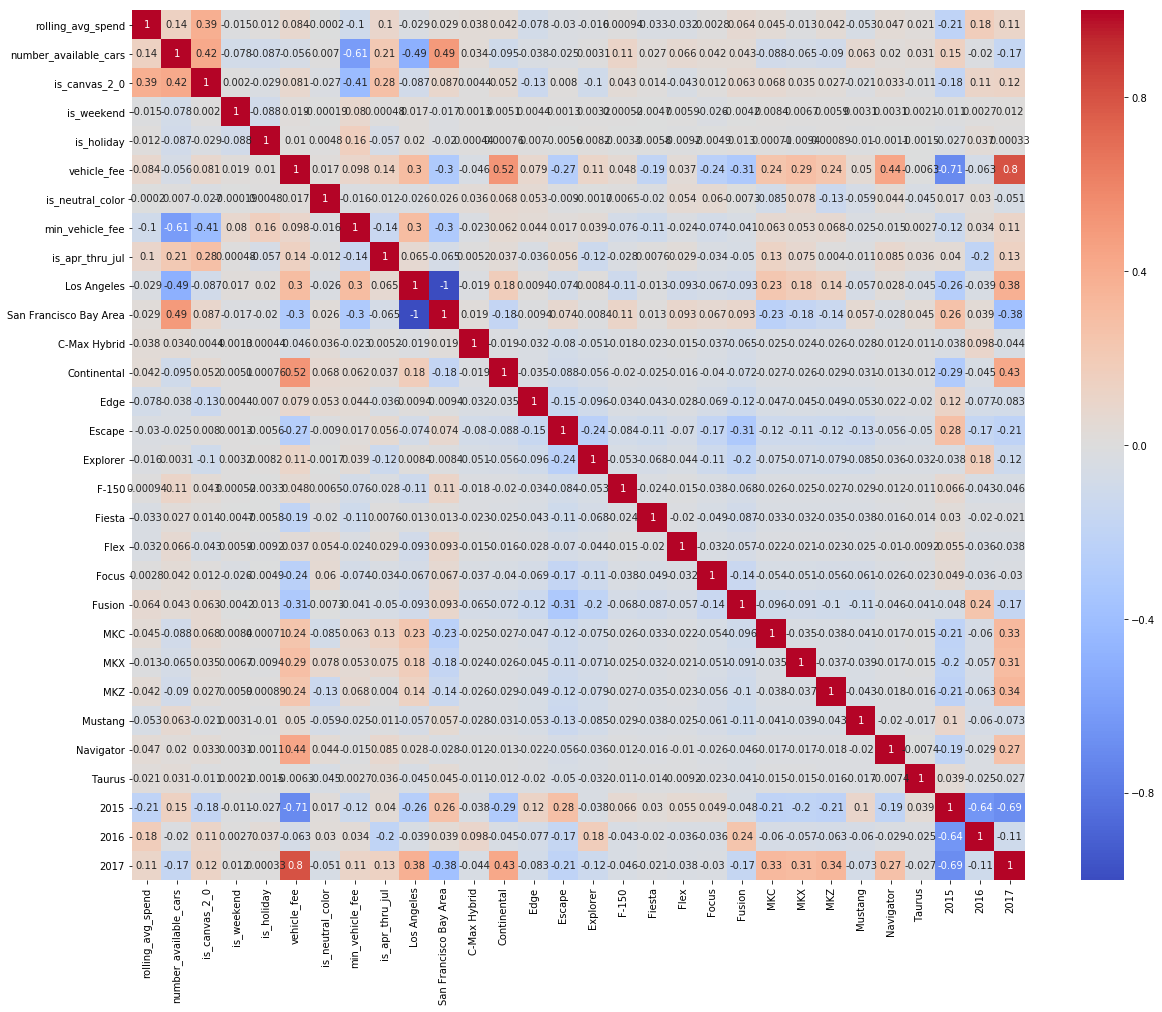

In [170]:
fig, ax = plt.subplots(figsize=(20,16))

sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')

In [199]:
features = num_cols + cat_cols
X = df[features]
y = df[target].values.ravel()

In [200]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=101,
                                                    test_size=0.25)

In [191]:
m = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [202]:
model = m.fit(X_train, y_train,
                cat_features=categorical_features_indices,
                eval_set=(X_test, y_test)
                )

In [203]:
cv_params = m.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params
#     , plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [207]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'F1',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

In [209]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

print('Simple model f1 score: {:.4}'.format(
    f1_score(y_test, model.predict(X_test))
))
print('')

print('Best model f1 score: {:.4}'.format(
    f1_score(y_test, best_model.predict(X_test))
))

Simple model validation f1 score: 0.1189

Best model validation f1 score: 0.1223
